In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from nba_api.stats.static import players

In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
import os
os.environ['KERAS_BACKEND'] = 'torch'

import keras

print(f"Keras version: {keras.__version__}")
print(f"Using backend: {keras.backend.backend()}")

Keras version: 3.12.0
Using backend: torch


In [5]:
# Check for GPU availability
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"✓ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"  Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print("  Training will be significantly faster on GPU!")
else:
    device = torch.device("cpu")
    print("⚠ No GPU detected - using CPU")
    print("  Training will be slower. Consider using Google Colab or Kaggle Kernel for free GPU access.")

✓ GPU available: NVIDIA GeForce RTX 4060 Laptop GPU
  Memory: 8.59 GB
  Training will be significantly faster on GPU!


# 0) Import X and Y + Helper Functions

In [ ]:
X = pd.read_csv('../datasets/X_pair.csv')
Y_df = pd.read_csv('../datasets/Y_pair.csv')

In [7]:
Y = Y_df['Hybrid Offensive RAPM']
possessions = Y_df['Possessions Played']

In [8]:
X.drop(columns=['PLAYER_NAME_A', 'PLAYER_NAME_B'], inplace=True)

In [9]:
feature_cols_A = [c for c in X.columns if c.endswith('_A')]
feature_cols_B = [c for c in X.columns if c.endswith('_B')]
feature_cols = [s[:-2] for s in feature_cols_A]  # remove _A/_B suffix

In [10]:
all_players_api = players.get_players()
all_players_df = pd.DataFrame(all_players_api)

In [11]:
def get_name(i):
    return all_players_df[all_players_df['id'] == i]['full_name'].values[0]

# 1) Build Leave-One-Player-Out (LOPO) splits

We cannot proceed with a typical train/validation/test split because the model can "cheat" an learn player embeddings and their interactions in the training phase. We use LOPO splits to track the model's performance on learning the players' inherent embeddings from their raw stats.

In [37]:
all_players = np.unique( X['Player_ID_A'].tolist() + X['Player_ID_B'].tolist() )

In [142]:
len(all_players)

682

In [38]:
# Identify held-out players for test and validation sets

rng = np.random.default_rng(21)
held_out_players_test = rng.choice(all_players, size= 60, replace=False)
held_out_players_val = rng.choice([p for p in all_players if p not in held_out_players_test], size=30, replace=False)

In [39]:
not_held_out_players = [p for p in all_players if p not in held_out_players_test and p not in held_out_players_val]

In [40]:
# Create masks for test, val, train splits

test_mask = X['Player_ID_A'].isin(held_out_players_test) | X['Player_ID_B'].isin(held_out_players_test)
val_mask = X['Player_ID_A'].isin(held_out_players_val) | X['Player_ID_B'].isin(held_out_players_val)
train_mask = ~(test_mask | val_mask)

In [150]:
test_mask.sum()

np.int64(1254)

In [151]:
val_mask.sum()

np.int64(628)

In [41]:
# Create training, validation, and test sets

X_train = X[train_mask]
Y_train = Y[train_mask]

X_val = X[val_mask]
Y_val = Y[val_mask]

X_test = X[test_mask]
Y_test = Y[test_mask]

w_train = possessions[train_mask]
w_val = possessions[val_mask]

w_train_sqrt = np.log(w_train)
w_val_sqrt = np.log(w_val)

In [42]:
# Standardize Y

y_mean = Y_train.mean()
y_std = Y_train.std()

y_train_norm = (Y_train - y_mean) / y_std
y_val_norm = (Y_val - y_mean) / y_std
y_test_norm = (Y_test - y_mean) / y_std

In [43]:
# Remove ids from feature_cols

feature_cols_A_noid = [c for c in feature_cols_A if c != 'Player_ID_A']
feature_cols_B_noid = [c for c in feature_cols_B if c != 'Player_ID_B']

In [44]:
def build_X(X_df):
    X_A = X_df[feature_cols_A_noid].to_numpy()
    X_B = X_df[feature_cols_B_noid].to_numpy()

    return X_A, X_B

In [45]:
# Split X into individual players: X_A and X_B for train, val, test

X_A_train, X_B_train = build_X(X_train)
X_A_val, X_B_val = build_X(X_val)
X_A_test, X_B_test = build_X(X_test)

In [46]:
# Standardize features, have to stack columns on train data (avoid leakage) 
# Also have to fit on unique players, not all rows (since some players will appear in many more rows)

full_X = pd.read_csv('player_x.csv') # all player features from data_cleaning.ipynb
full_X = full_X[full_X['PLAYER_ID'].isin(all_players)].copy().reset_index(drop=True)

train_players_stats = full_X[full_X['PLAYER_ID'].isin(not_held_out_players)].copy().reset_index(drop=True).drop(columns=['PLAYER_ID', 'PLAYER_NAME', 'SEASON']).to_numpy().astype(np.float32)
scaler = StandardScaler()
scaler.fit(train_players_stats)

X_A_train_scaled = scaler.transform(X_A_train)
X_B_train_scaled = scaler.transform(X_B_train)
X_A_val_scaled = scaler.transform(X_A_val)
X_B_val_scaled = scaler.transform(X_B_val)
X_A_test_scaled = scaler.transform(X_A_test)
X_B_test_scaled = scaler.transform(X_B_test)


# 2) Implement Model

In [101]:
def build_player_encoder(feature_dim, embedding_dim = 32, n_archetypes = 8):
    input = keras.Input(shape=(feature_dim,), name='player_features')
    x = keras.layers.Dense(256, activation='relu')(input)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(64, activation='relu')(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(32, activation='relu')(x)

    x = keras.layers.BatchNormalization()(x)
    
    embedding = keras.layers.Dense(embedding_dim, activation=None, name = 'player_embedding')(x)

    archetype_logits = keras.layers.Dense(n_archetypes, activation=None, name='archetype_logits')(x)
    archetype_probs = keras.layers.Softmax(name='archetype_probs')(archetype_logits)

    model = keras.Model(inputs=input, outputs=[embedding, archetype_probs], name='player_encoder')
    return model

In [132]:
player_encoder = build_player_encoder(feature_dim=X_A_train_scaled.shape[1])
input_A = keras.Input(shape=(X_A_train_scaled.shape[1],), name='player_1_input')
input_B = keras.Input(shape=(X_B_train_scaled.shape[1],), name='player_2_input')

emb_A, arch_A = player_encoder(input_A)
emb_B, arch_B = player_encoder(input_B)

#EMBEDDING INTERACTIONS

phi = keras.layers.Dense(16, activation='relu')

phi_A = phi(emb_A)
phi_B = phi(emb_B)

emb_add = keras.layers.Add()([phi_A, phi_B])

phi_diff = keras.layers.Dense(16, activation = 'relu')

phi_A_diff = phi_diff(emb_A)
phi_B_diff = phi_diff(emb_B)

diff_vec = keras.layers.Subtract(name="emb_diff_raw")([phi_A_diff, phi_B_diff])

emb_diff = keras.layers.Lambda(lambda t: keras.ops.abs(t), name="emb_abs_diff")(diff_vec)

phi_prod = keras.layers.Dense(16, activation='relu')

phi_A_prod = phi_prod(emb_A)
phi_B_prod = phi_prod(emb_B)

emb_prod = keras.layers.Multiply(name='emb_prod')([phi_A_prod, phi_B_prod])

#ARCHETYPE INTERACTIONS

arch_prod = keras.layers.Multiply(name='arch_interaction_matrix')([arch_A, arch_B])

diff_vec_arch = keras.layers.Subtract(name="arch_diff_raw")([arch_A, arch_B])
arch_diff = keras.layers.Lambda(lambda t: keras.ops.abs(t), name="arch_abs_diff")(diff_vec_arch)

# PAIR INPUT

pair_input = keras.layers.Concatenate(name='pair_features')(
    [emb_add, emb_prod, emb_diff, arch_diff, arch_prod]
)

x = keras.layers.Dense(512, activation='relu')(pair_input)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(32, activation='relu')(x)

x = keras.layers.BatchNormalization()(x)

output = keras.layers.Dense(1, activation = None, name='output')(x)

model = keras.Model(inputs=[input_A, input_B], outputs=output, name='synergy_model')
model.summary()


Model: "synergy_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ player_1_input      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_2_input      │ (None, 37)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ player_encoder      │ [(None, 32),      │     29,704 │ player_1_input[0… │
│ (Functional)        │ (None, 8)]        │            │ player_2_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_117 (Dense)   │ (None, 16)        │        528 │ player_encoder[0… │
│                     │                   │            │ player_encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_116 (Dense)   │ (None, 16)        │        528 │ player_encoder[0… │
│                     │                   │            │ player_encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_118 (Dense)   │ (None, 16)        │        528 │ player_encoder[0… │
│                     │                   │            │ player_encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_diff_raw        │ (None, 16)        │          0 │ dense_117[0][0],  │
│ (Subtract)          │                   │            │ dense_117[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arch_diff_raw       │ (None, 8)         │          0 │ player_encoder[0… │
│ (Subtract)          │                   │            │ player_encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_15 (Add)        │ (None, 16)        │          0 │ dense_116[0][0],  │
│                     │                   │            │ dense_116[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_prod (Multiply) │ (None, 16)        │          0 │ dense_118[0][0],  │
│                     │                   │            │ dense_118[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_abs_diff        │ (None, 16)        │          0 │ emb_diff_raw[0][… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arch_abs_diff       │ (None, 8)         │          0 │ arch_diff_raw[0]… │
│ (Lambda)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ arch_interaction_m… │ (None, 8)         │          0 │ player_encoder[0… │
│ (Multiply)          │                   │            │ player_encoder[1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pair_features       │ (None, 64)        │          0 │ add_15[0][0],     │
│ (Concatenate)       │                   │            │ emb_prod[0][0],   │
│                     │                   │            │ emb_abs_diff[0][… │
│                     │                   │            │ arch_abs_diff[0]… │
│                     │                   │            │ arch_interaction… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_119 (Dense)   │ (None, 512)       │     33,280 │ pair_features[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_62          │ (None, 512)       │          0 │ dense_119[0][0]   │
│ (Dropout)           │                   │            │                 

 Total params: 134,521 (525.47 KB)

 Trainable params: 134,393 (524.97 KB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
# Compile the model

model.compile(
    optimizer= keras.optimizers.Adam(learning_rate=0.00025),
    loss='mse',
    metrics=['mae']
)

In [134]:
# Callbacks

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

# 3) Train the model

In [135]:
history = model.fit(x = [X_A_train_scaled, X_B_train_scaled],
    y = y_train_norm.to_numpy(),
    sample_weight = w_train_sqrt.to_numpy(),
    validation_data = ([X_A_val_scaled, X_B_val_scaled], y_val_norm.to_numpy(), w_val_sqrt.to_numpy()),
    epochs = 100,
    batch_size = 32,
    callbacks = callbacks,
    verbose = 2
)

Epoch 1/100
172/172 - 6s - 34ms/step - loss: 14.2433 - mae: 1.0761 - val_loss: 8.1744 - val_mae: 0.8337
Epoch 2/100
172/172 - 6s - 35ms/step - loss: 9.7918 - mae: 0.9025 - val_loss: 8.1298 - val_mae: 0.8309
Epoch 3/100
172/172 - 6s - 35ms/step - loss: 8.7291 - mae: 0.8536 - val_loss: 8.0974 - val_mae: 0.8309
Epoch 4/100
172/172 - 6s - 34ms/step - loss: 8.1948 - mae: 0.8288 - val_loss: 8.2223 - val_mae: 0.8413
Epoch 5/100
172/172 - 6s - 36ms/step - loss: 8.0946 - mae: 0.8248 - val_loss: 8.0787 - val_mae: 0.8331
Epoch 6/100
172/172 - 6s - 35ms/step - loss: 7.8965 - mae: 0.8132 - val_loss: 8.0470 - val_mae: 0.8322
Epoch 7/100
172/172 - 6s - 34ms/step - loss: 7.7844 - mae: 0.8060 - val_loss: 8.0758 - val_mae: 0.8325
Epoch 8/100
172/172 - 6s - 34ms/step - loss: 7.8038 - mae: 0.8081 - val_loss: 8.0060 - val_mae: 0.8288
Epoch 9/100
172/172 - 6s - 34ms/step - loss: 7.8126 - mae: 0.8087 - val_loss: 8.0237 - val_mae: 0.8303
Epoch 10/100
172/172 - 6s - 35ms/step - loss: 7.7404 - mae: 0.8043 - val

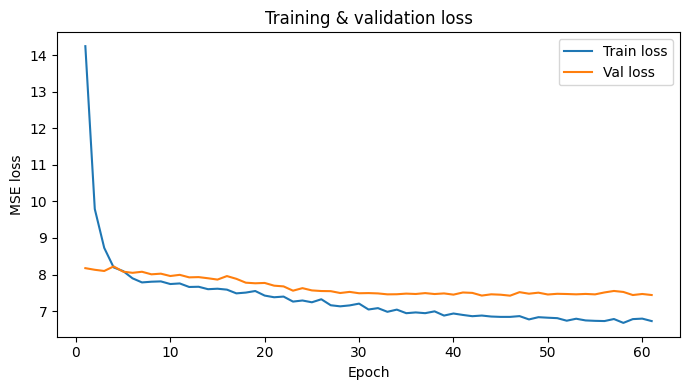

In [136]:
# Visualize training history

hist = history.history
epochs = range(1, len(hist['loss']) + 1)

plt.figure(figsize=(7,4))
plt.plot(epochs, hist['loss'], label='Train loss')
plt.plot(epochs, hist['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE loss')
plt.title('Training & validation loss')
plt.legend()
plt.tight_layout()
plt.show()

In [137]:
y_train_pred = model.predict([X_A_train_scaled, X_B_train_scaled])
y_val_pred = model.predict([X_A_val_scaled, X_B_val_scaled])
y_test_pred = model.predict([X_A_test_scaled, X_B_test_scaled])

172/172 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [138]:
y_train_pred_rescaled = y_train_pred.flatten() * y_std + y_mean
y_val_pred_rescaled = y_val_pred.flatten() * y_std + y_mean
y_test_pred_rescaled = y_test_pred.flatten() * y_std + y_mean

In [139]:
from sklearn.metrics import r2_score

r2_train = r2_score(Y_train.to_numpy(), y_train_pred_rescaled)
r2_val = r2_score(Y_val.to_numpy(), y_val_pred_rescaled)
r2_test = r2_score(Y_test.to_numpy(), y_test_pred_rescaled)

In [140]:
print(f"Train R²: {r2_train:.4f}")
print(f"Val   R²: {r2_val:.4f}")
print(f"Test  R²: {r2_test:.4f}")

Train R²: 0.1286
Val   R²: 0.0716
Test  R²: 0.0779
